In [13]:
import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from IPython.display import Audio
import sys
sys.path.append('lib')
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from sklearn.model_selection import train_test_split

In [14]:
#Cargamos los archivos de datos de audios
audio_files = glob.glob('/content/*.mp3')
print(f"Archivos de audio encontrados: {audio_files}")

audio_data_list = []
sample_rates = []
#establecemos la taza de muestreo
fixed_sample_rate = 16000

for audio_file in audio_files:
    audio_data, sr = librosa.load(audio_file, sr=None)
    audio_data_list.append(audio_data)
    sample_rates.append(sr)



Archivos de audio encontrados: ['/content/common_voice_es_41243968.mp3']


Se cargaron 1 archivos de audio


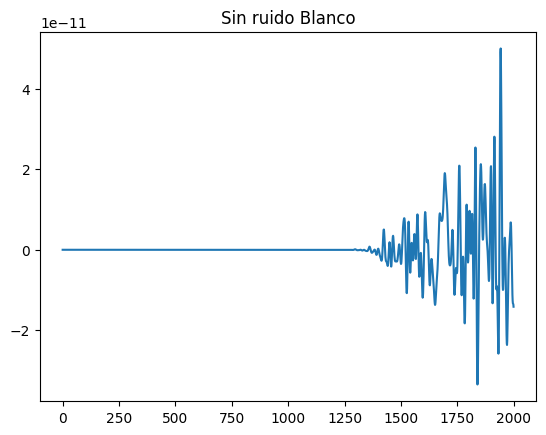

In [15]:
print(f"Se cargaron {len(audio_data_list)} archivos de audio")
plt.plot(audio_data_list[0][:2000])
plt.title("Sin ruido Blanco")
plt.show()

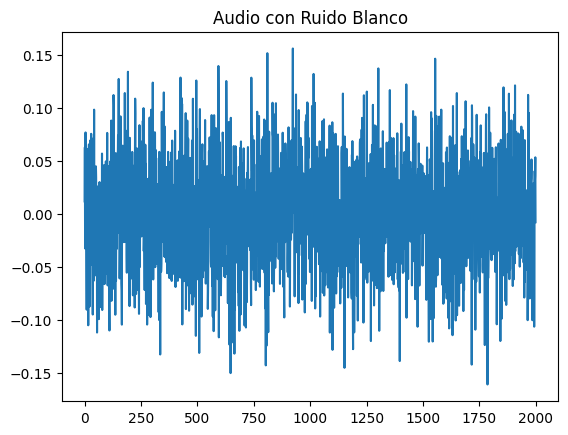

In [ ]:
def agregar_ruido(audio_data, noise_level=0.05): #establecemos un alto nivel de ruido para que el modedlo sea mas efectivo
    noise = np.random.randn(len(audio_data))
    noise = noise * noise_level
    noisy_audio = audio_data + noise
    return np.clip(noisy_audio, -1.0, 1.0)

# Agregar ruido a todos los archivos
noisy_audio_list = [agregar_ruido(audio_data) for audio_data in audio_data_list]

# Visualizar uno de los archivos con ruido
plt.plot(noisy_audio_list[0][:2000])
plt.title("Audio con Ruido Blanco")
plt.show()

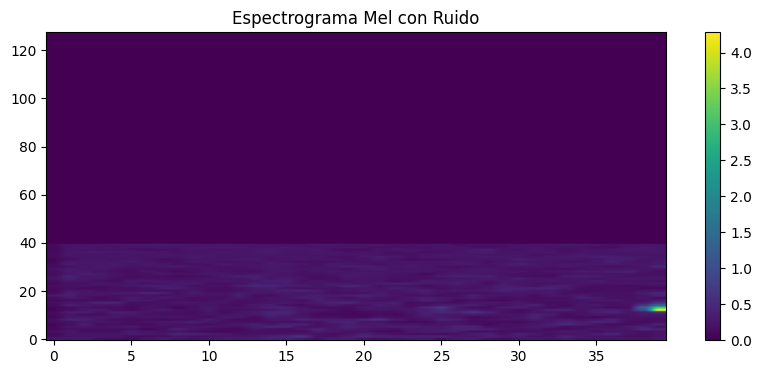

In [ ]:
def obtener_espectrograma_mel(audio_data, target_shape):
    # Calcular el espectrograma Mel
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=fixed_sample_rate, n_mels=40, fmax=8000)

    # Redimensionar el espectrograma a la forma target_shape
    mel_spectrogram_resized = np.zeros(target_shape)
    mel_spectrogram_resized[:mel_spectrogram.shape[0], :mel_spectrogram.shape[1]] = mel_spectrogram[:target_shape[0], :target_shape[1]]

    return mel_spectrogram_resized

# Definir la forma objetivo del espectrograma
target_shape = (128, 40)

# Obtener los espectrogramas Mel para los audios limpios y con ruido
mel_spectrograms_clean = [obtener_espectrograma_mel(audio_data, target_shape) for audio_data in audio_data_list]
mel_spectrograms_noisy = [obtener_espectrograma_mel(noisy_audio, target_shape) for noisy_audio in noisy_audio_list]

# Visualizar un espectrograma de ejemplo
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrograms_noisy[0], aspect='auto', origin='lower')
plt.title("Espectrograma Mel con Ruido")
plt.colorbar()

In [ ]:
mel_spectrograms_noisy_reshaped = np.expand_dims(mel_spectrograms_noisy, axis=-1)
mel_spectrograms_clean_reshaped = np.expand_dims(mel_spectrograms_clean, axis=-1)

# Verificar las dimensiones después de agregar el canal
print(f"Forma de mel_spectrograms_noisy_reshaped: {mel_spectrograms_noisy_reshaped.shape}")
print(f"Forma de mel_spectrograms_clean_reshaped: {mel_spectrograms_clean_reshaped.shape}")

Forma de mel_spectrograms_noisy_reshaped: (576, 128, 40, 1)
Forma de mel_spectrograms_clean_reshaped: (576, 128, 40, 1)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout
from tensorflow.keras.optimizers import Adam

# Crear el autoencoder
def crear_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    # Codificador con más capas y Dropout
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = Dropout(0.3)(x)  # Regularización con Dropout
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)  # Regularización con Dropout
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(128, activation='relu')(x)

    # Decodificador
    x = Dense(64 * input_shape[0] * input_shape[1], activation='relu')(encoded)
    x = Reshape((input_shape[0], input_shape[1], 64))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='linear', padding='same')(x)  # Usar activación lineal si no está en [0, 1]

    # Modelo
    autoencoder = Model(inputs=input_layer, outputs=decoded)

    # Compilar el modelo
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

    return autoencoder

# Definir las dimensiones de entrada (espectrograma)
input_shape = mel_spectrograms_noisy_reshaped[0].shape  # Esto será (128, 40, 1)
autoencoder = crear_autoencoder(input_shape)

# Entrenar el modelo
autoencoder.fit(mel_spectrograms_noisy_reshaped, mel_spectrograms_clean_reshaped, epochs=18, batch_size=32, validation_split=0.2)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - loss: 21.2010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 20.2112
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 15.7593
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 20.8035
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 23.1972
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - loss: 25.0144
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 19.2062
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 14.4983
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - loss: 19.3215
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - loss: 15.2505
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - loss: 19.3600
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - loss: 23.1987
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 15.8155
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 19.6656
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 19

In [16]:
import matplotlib.pyplot as plt

# Entrenar el modelo y guardar el historial
history = autoencoder.fit(mel_spectrograms_noisy_reshaped, mel_spectrograms_clean_reshaped, epochs=50, batch_size=16)

# Graficar el progreso de la pérdida (loss) durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida (Loss)')
plt.title('Progreso de la Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'autoencoder' is not defined

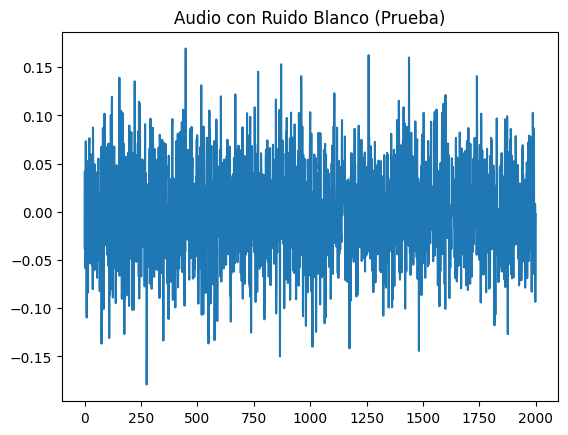

In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Función para agregar ruido a un audio
def agregar_ruido(audio_data, noise_level=0.05):
    noise = np.random.randn(len(audio_data))
    noise = noise * noise_level
    noisy_audio = audio_data + noise
    return np.clip(noisy_audio, -1.0, 1.0)

# Cargar el archivo de audio de prueba
audio_test_path = 'common_voice_es_41243968.mp3'  # Ruta del archivo de prueba
audio_data_test, sr_test = librosa.load(audio_test_path, sr=None)

# Agregar ruido al audio de prueba
noisy_audio_test = agregar_ruido(audio_data_test)
plt.plot(noisy_audio_test[:2000])
plt.title("Audio con Ruido Blanco (Prueba)")
plt.show()


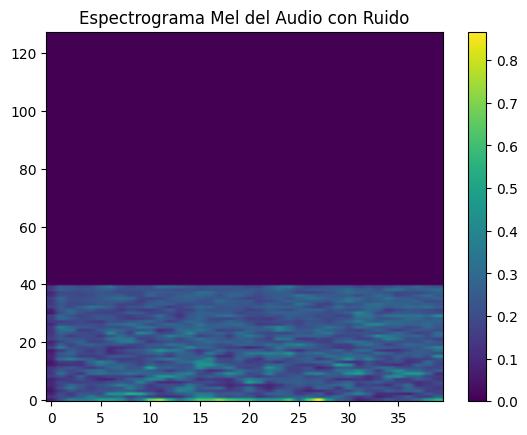

In [9]:
# Función para obtener el espectrograma Mel de un audio
def obtener_espectrograma_mel(audio_data, target_shape):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=16000  , n_mels=40, fmax=8000)
    mel_spectrogram_resized = np.zeros(target_shape)
    mel_spectrogram_resized[:mel_spectrogram.shape[0], :mel_spectrogram.shape[1]] = mel_spectrogram[:target_shape[0], :target_shape[1]]
    return mel_spectrogram_resized

# Definir la forma objetivo del espectrograma (la misma que usaste para entrenar)
target_shape = (128, 40)

# Convertir el audio ruidoso en un espectrograma Mel
mel_spectrogram_test_noisy = obtener_espectrograma_mel(noisy_audio_test, target_shape)

# Visualizar el espectrograma Mel con ruido
plt.imshow(mel_spectrogram_test_noisy, aspect='auto', origin='lower')
plt.title("Espectrograma Mel del Audio con Ruido")
plt.colorbar()
plt.show()


In [11]:
# Asegurarnos de que el input tenga la forma adecuada para el modelo (agregar una dimensión extra para el batch size)
mel_spectrogram_test_noisy_reshaped = np.expand_dims(mel_spectrogram_test_noisy, axis=-1)
mel_spectrogram_test_noisy_reshaped = np.expand_dims(mel_spectrogram_test_noisy_reshaped, axis=0)  # Añadir la dimensión de batch

# Usar el autoencoder para predecir el espectrograma limpio
mel_spectrogram_test_clean_pred = autoencoder.predict(mel_spectrogram_test_noisy_reshaped)

# Mostrar el espectrograma Mel reconstruido (sin ruido)
plt.imshow(mel_spectrogram_test_clean_pred[0, :, :, 0], aspect='auto', origin='lower')
plt.title("Espectrograma Mel Predicho (Limpio)")
plt.colorbar()
plt.show()


NameError: name 'autoencoder' is not defined

In [ ]:
# Convertir el espectrograma Mel limpio a una señal de audio
mel_spectrogram_clean_pred_rescaled = mel_spectrogram_test_clean_pred[0, :, :, 0]  # Sacar la dimensión extra

# Usar librosa para invertir el espectrograma Mel a audio
audio_clean_pred = librosa.feature.inverse.mel_to_audio(mel_spectrogram_clean_pred_rescaled, sr=fixed_sample_rate)

# Reproducir el audio limpio (sin ruido)
print("Reproduciendo el audio limpio predicho...")
Audio(audio_clean_pred, rate=fixed_sample_rate)


In [ ]:
# Reproducir el audio original (sin ruido)
print("Reproduciendo el audio original limpio...")
Audio(audio_data_test, rate=fixed_sample_rate)

# Reproducir el audio ruidoso (para comparar)
print("Reproduciendo el audio ruidoso...")
Audio(noisy_audio_test, rate=fixed_sample_rate)
#########       #################

In [ ]:
# Función para predecir y eliminar el ruido de un nuevo audio
def eliminar_ruido(model, audio_data, sr):
    # Convertir el audio ruidoso en un espectrograma Mel
    mel_spectrogram_noisy = obtener_espectrograma_mel(audio_data, sr)

    # Redimensionar el espectrograma para el modelo
    mel_spectrogram_noisy_reshaped = np.expand_dims(mel_spectrogram_noisy, axis=-1)
    mel_spectrogram_noisy_reshaped = np.expand_dims(mel_spectrogram_noisy_reshaped, axis=0)

    # Predecir (eliminar el ruido)
    mel_spectrogram_clean = model.predict(mel_spectrogram_noisy_reshaped)

    # Invertir el espectrograma Mel a audio
    clean_audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram_clean[0].squeeze(), sr=sr)

    return clean_audio

# Probar el modelo con un nuevo audio
nuevo_audio, sr = librosa.load('ruta/a/tu/audio_con_ruido.mp3', sr=fixed_sample_rate)
audio_limpio = eliminar_ruido(autoencoder, nuevo_audio, sr)
##################
# Reproducir el audio limpio
Audio(audio_limpio, rate=sr)


In [ ]:
for audio in audio_data_list[:1]:  # Solo tomar el primer archivo como ejemplo
    display(Audio(audio, rate=sr))

# Reproducir los audios con ruido
for noisy_audio in noisy_audio_list[:1]:  # Solo tomar el primer archivo con ruido
    display(Audio(noisy_audio, rate=sr))

In [ ]:
import librosa.display

# Convertir audio a espectrograma de Mel
def obtener_espectrograma_mel(audio_data, sr, n_mels=40, fft_size=1024, hop_length=256):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels,
                                                     n_fft=fft_size, hop_length=hop_length)
    return mel_spectrogram

# Convertir las señales de audio a espectrogramas Mel
mel_spectrograms = [obtener_espectrograma_mel(audio_data, sr) for audio_data, sr in zip(audio_data_list, sample_rates)]
mel_clean_spectrograms = [obtener_espectrograma_mel(audio_data, sr) for audio_data, sr in zip(audio_data_list, sample_rates)]


In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Función para ajustar todos los espectrogramas a la misma forma
def ajustar_espectrograma(mel_spectrogram, target_shape):
    # Cambiar el uso de fix_length para que reciba el parámetro size como un argumento con nombre
    mel_spectrogram_resized = librosa.util.fix_length(mel_spectrogram, size=target_shape[1], axis=1)
    return mel_spectrogram_resized

# Ajustar todos los espectrogramas Mel a la misma forma
target_shape = (40, 128)  # Establece las dimensiones deseadas, 40 Mel-filters y 128 frames de tiempo
mel_spectrograms_resized = [ajustar_espectrograma(mel, target_shape) for mel in mel_spectrograms]
mel_clean_spectrograms_resized = [ajustar_espectrograma(mel, target_shape) for mel in mel_clean_spectrograms]

# Normalizar los espectrogramas Mel de las señales ruidosas y limpias
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalizar las señales limpias y ruidosas
X_train = np.array([scaler.fit_transform(mel) for mel in mel_spectrograms_resized])
y_train = np.array([scaler.fit_transform(mel) for mel in mel_clean_spectrograms_resized])


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Reshape
from keras.optimizers import Adam

# Definir la arquitectura del autoencoder
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Forma de los espectrogramas Mel

# Encoder
encoded = Dense(512, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(256, activation='relu')(encoded)

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)

# El número de unidades en la siguiente capa densa debe ser 40 * 128 = 5120
decoded = Dense(128, activation='sigmoid')(decoded)  # Decodificación a un vector

# Reshape de la salida a la forma deseada (40, 128) que es la forma de tu espectrograma
decoded = Reshape((40, 128))(decoded)  # Este es el tamaño correcto para tu salida final

autoencoder = Model(input_layer, decoded)

# Compilar el modelo (cambio de lr por learning_rate)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entrenar el modelo
autoencoder.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)


Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.1218 - val_loss: 0.1423
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0284 - val_loss: 0.1026
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 0.0231 - val_loss: 0.0894
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.0178 - val_loss: 0.0815
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0138 - val_loss: 0.0816
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0116 - val_loss: 0.0814
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0099 - val_loss: 0.0765
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0087 - val_loss: 0.0758
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0078 - val_loss: 0.0700
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0073 - val_loss: 0.0665
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0065 - val_loss: 0.0602
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


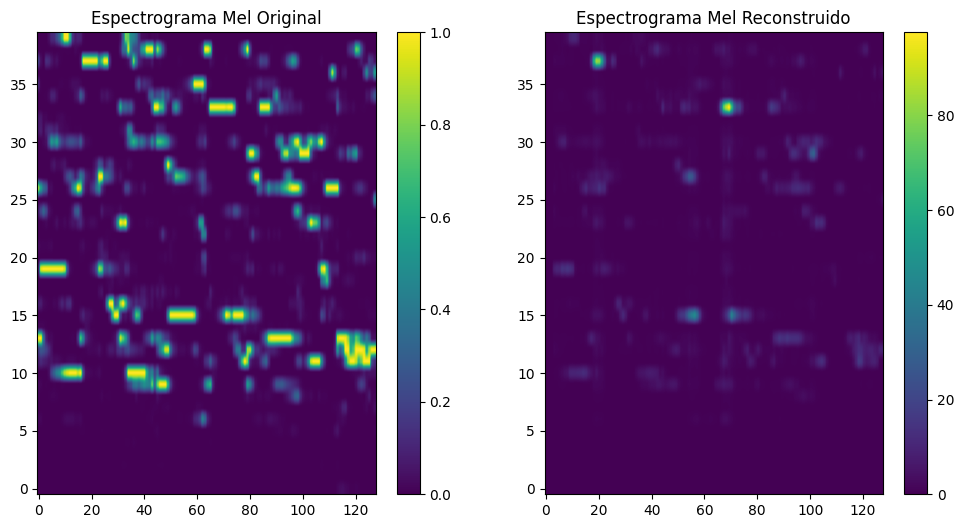

Reproduciendo el audio original...


In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import Audio

# Función para obtener el espectrograma Mel y ajustarlo a la misma forma
def obtener_espectrograma_mel(audio_path, target_shape):
    # Cargar el archivo de audio
    audio_data, sr = librosa.load(audio_path, sr=None)  # Usamos sr=None para mantener la tasa de muestreo original

    # Calcular el espectrograma Mel
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, fmax=8000)

    # Redimensionar el espectrograma para que tenga la forma target_shape
    mel_spectrogram_resized = np.resize(mel_spectrogram, target_shape)

    # Normalizar el espectrograma
    #scaler = MinMaxScaler(feature_range=(0, 1))
    mel_spectrogram_scaled = scaler.fit_transform(mel_spectrogram_resized)

    return mel_spectrogram_scaled, scaler, sr, audio_data, mel_spectrogram_resized

# Ruta del archivo de audio de prueba
audio_path = 'common_voice_es_41243968.mp3'
#audio_data, sr = librosa.load(audio_path, sr=None)

# Obtener el espectrograma Mel del audio de prueba
target_shape = (40, 128)  # Tamaño que corresponde al modelo entrenado
mel_spectrogram_test, scaler, sr, audio_data, mel_spectrogram_resized = obtener_espectrograma_mel(audio_path, target_shape)

# Asegurarnos de que la entrada sea la forma correcta para el modelo
mel_spectrogram_test_input = np.expand_dims(mel_spectrogram_test, axis=0)  # Añadir dimensión de batch

# Predecir con el autoencoder
reconstructed_spectrogram = autoencoder.predict(mel_spectrogram_test_input)

# Desnormalizar el espectrograma reconstruido
reconstructed_spectrogram_rescaled = scaler.inverse_transform(reconstructed_spectrogram[0])

# Inversión del espectrograma Mel reconstruido a audio
reconstructed_audio = librosa.feature.inverse.mel_to_audio(reconstructed_spectrogram_rescaled, sr=sr)

# Inversión del espectrograma Mel original a audio
original_audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram_resized, sr=sr)

# Mostrar los resultados

# Espectrograma original
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mel_spectrogram_test, aspect='auto', origin='lower')
plt.title('Espectrograma Mel Original')
plt.colorbar()

# Espectrograma reconstruido
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_spectrogram_rescaled, aspect='auto', origin='lower')
plt.title('Espectrograma Mel Reconstruido')
plt.colorbar()

plt.show()

# Reproducir el audio original
print("Reproduciendo el audio original...")
Audio(audio_data, rate=sr)  # Asegúrate de retornar el objeto




In [ ]:
# Reproducir el audio reconstruido
print("Reproduciendo el audio reconstruido...")
Audio(reconstructed_audio, rate=sr)  # Asegúrate de retornar el objeto

Reproduciendo el audio reconstruido...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


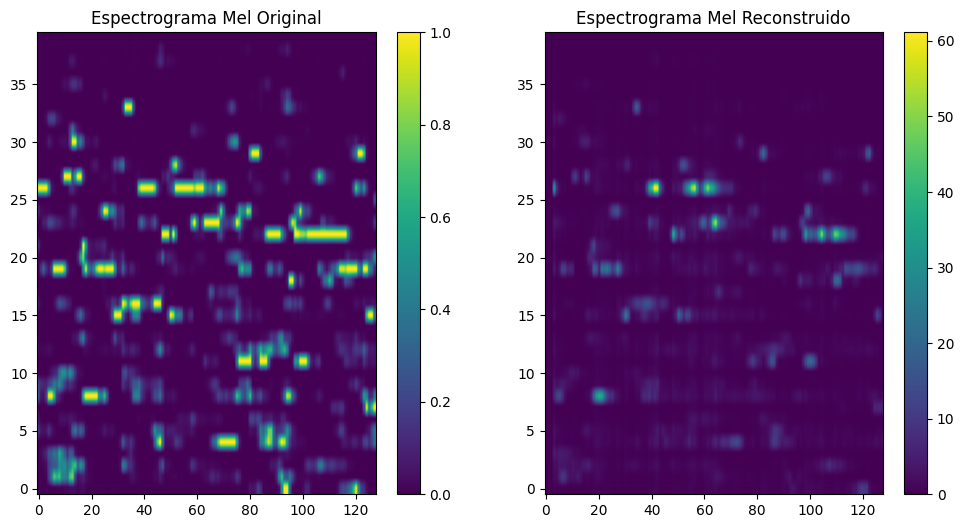

Reproduciendo el audio original...
Reproduciendo el audio reconstruido...


In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import Audio

# Función para obtener el espectrograma Mel y ajustarlo a la misma forma
def obtener_espectrograma_mel(audio_path, target_shape):
    # Cargar el archivo de audio
    audio_data, sr = librosa.load(audio_path, sr=None)  # Usamos sr=None para mantener la tasa de muestreo original

    # Calcular el espectrograma Mel
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=40, fmax=8000)

    # Redimensionar el espectrograma para que tenga la forma target_shape
    mel_spectrogram_resized = np.resize(mel_spectrogram, target_shape)

    # Normalizar el espectrograma
    scaler = MinMaxScaler(feature_range=(0, 1))
    mel_spectrogram_scaled = scaler.fit_transform(mel_spectrogram_resized)

    return mel_spectrogram_scaled, scaler, sr, audio_data, mel_spectrogram_resized

# Ruta del archivo de audio de prueba
audio_path = 'common_voice_es_41243968.mp3'

# Obtener el espectrograma Mel del audio de prueba
target_shape = (40, 128)  # Tamaño que corresponde al modelo entrenado
mel_spectrogram_test, scaler, sr, audio_data, mel_spectrogram_resized = obtener_espectrograma_mel(audio_path, target_shape)

# Asegurarnos de que la entrada sea la forma correcta para el modelo
mel_spectrogram_test_input = np.expand_dims(mel_spectrogram_test, axis=0)  # Añadir dimensión de batch

# Predecir con el autoencoder
reconstructed_spectrogram = autoencoder.predict(mel_spectrogram_test_input)

# Desnormalizar el espectrograma reconstruido
reconstructed_spectrogram_rescaled = scaler.inverse_transform(reconstructed_spectrogram[0])

# Inversión del espectrograma Mel reconstruido a audio
reconstructed_audio = librosa.feature.inverse.mel_to_audio(reconstructed_spectrogram_rescaled, sr=sr)

# Inversión del espectrograma Mel original a audio
original_audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram_resized, sr=sr)

# Mostrar los resultados

# Espectrograma original
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mel_spectrogram_test, aspect='auto', origin='lower')
plt.title('Espectrograma Mel Original')
plt.colorbar()

# Espectrograma reconstruido
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_spectrogram_rescaled, aspect='auto', origin='lower')
plt.title('Espectrograma Mel Reconstruido')
plt.colorbar()

plt.show()

# Reproducir el audio original
print("Reproduciendo el audio original...")
Audio(audio_data, rate=sr)

# Reproducir el audio reconstruido
print("Reproduciendo el audio reconstruido...")
Audio(reconstructed_audio, rate=sr)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


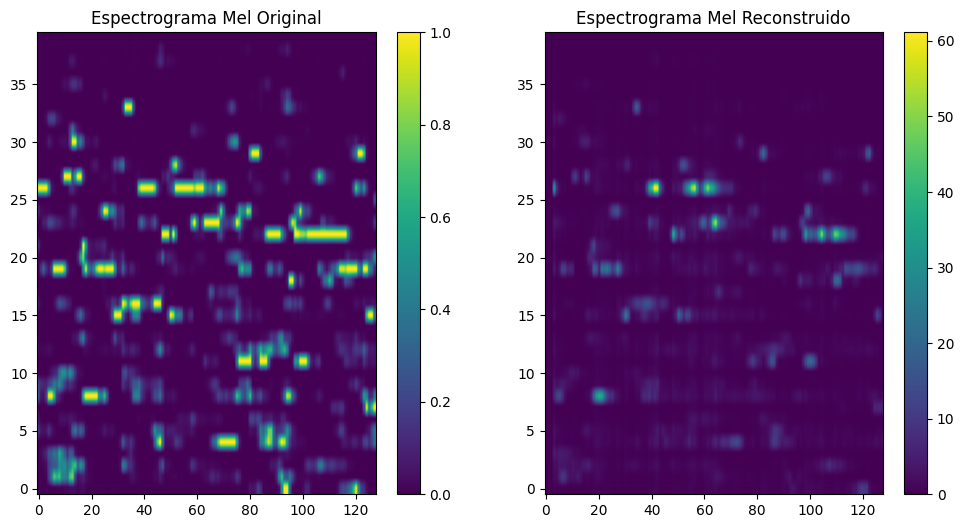

In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import Audio

# Función para obtener el espectrograma Mel y ajustarlo a la misma forma
def obtener_espectrograma_mel(audio_path, target_shape):
    # Cargar el archivo de audio
    audio_data, sr = librosa.load(audio_path, sr=None)  # Usamos sr=None para mantener la tasa de muestreo original

    # Calcular el espectrograma Mel
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=40, fmax=8000)

    # Redimensionar el espectrograma para que tenga la forma target_shape
    mel_spectrogram_resized = np.resize(mel_spectrogram, target_shape)

    # Normalizar el espectrograma
    scaler = MinMaxScaler(feature_range=(0, 1))
    mel_spectrogram_scaled = scaler.fit_transform(mel_spectrogram_resized)

    return mel_spectrogram_scaled, scaler, sr

# Ruta del archivo de audio de prueba
audio_path = 'common_voice_es_41243968.mp3'

# Obtener el espectrograma Mel del audio de prueba
target_shape = (40, 128)  # Tamaño que corresponde al modelo entrenado
mel_spectrogram_test, scaler, sr = obtener_espectrograma_mel(audio_path, target_shape)

# Asegurarnos de que la entrada sea la forma correcta para el modelo
mel_spectrogram_test_input = np.expand_dims(mel_spectrogram_test, axis=0)  # Añadir dimensión de batch

# Predecir con el autoencoder
reconstructed_spectrogram = autoencoder.predict(mel_spectrogram_test_input)

# Desnormalizar el espectrograma reconstruido
reconstructed_spectrogram_rescaled = scaler.inverse_transform(reconstructed_spectrogram[0])

# Mostrar los resultados


# Espectrograma original
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mel_spectrogram_test, aspect='auto', origin='lower')
plt.title('Espectrograma Mel Original')
plt.colorbar()

# Espectrograma reconstruido
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_spectrogram_rescaled, aspect='auto', origin='lower')
plt.title('Espectrograma Mel Reconstruido')
plt.colorbar()

plt.show()
